In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim

INPUT_PATH = './yelp_academic_dataset_review.json'
DATASET_CSV_PATH = './yelp_reviews_gen.csv'
PATH_TO_YELP_REVIEWS = INPUT_PATH

# Use cuda if present
device = torch.device("cuda")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
with open(PATH_TO_YELP_REVIEWS, 'r') as f:
  chunks = pd.read_json(f, lines=True, chunksize = 100)
  for c_data in chunks:
    x = pd.DataFrame.from_dict(c_data)
    x.to_csv ('yelp_reviews_gen.csv',  mode='a', index=False, header=False)

In [ ]:
from google.colab import files
files.download('yelp_reviews_gen.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
! gdown --id 1tO13aN1nnJqupL-JkydxBg7H5ET4y0HM

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tO13aN1nnJqupL-JkydxBg7H5ET4y0HM
To: /content/yelp_reviews_gen.csv
100% 4.67G/4.67G [00:36<00:00, 129MB/s]


In [4]:
top_data_df = pd.read_csv(DATASET_CSV_PATH)
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


Number of rows per star rating:
5.0    3231628
4.0    1452918
1.0    1069562
3.0     691934
2.0     544240
Name: stars, dtype: int64


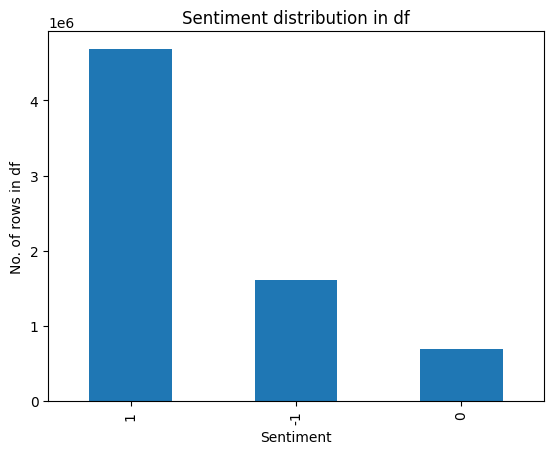

In [5]:
print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [6]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    10000
-1    10000
 0    10000
Name: sentiment, dtype: int64


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,kMYZUhpyJbdCl8EFO-Rd5Q,NYAJpO24FyjoHvRYC06ztw,KP5OncF2jhT7_J1phHPPww,5.0,0.0,0.0,0.0,The food was amazing and Manuel was even bette...,2018-09-07 01:09:10,1
3,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1.0,0.0,1.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
5,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
6,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1.0,0.0,1.0,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
8,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0.0,2.0,0.0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1
9,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2.0,0.0,0.0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1
12,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5.0,2.0,0.0,0.0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,1
13,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,0.0,0.0,0.0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45,1
14,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4.0,0.0,0.0,0.0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,1
15,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0.0,0.0,0.0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,1


In [ ]:
# Removing the stop words
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("Restaurant had a really good service!!"))

Restaurant good service!!


In [7]:
# Tokenize the text column to get the new column 'tokenized_text'
from gensim.utils import simple_preprocess
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

0     [the, food, was, amazing, and, manuel, was, ev...
3     [ve, taken, lot, of, spin, classes, over, the,...
5     [wow, yummy, different, delicious, our, favori...
6     [cute, interior, and, owner, gave, us, tour, o...
8     [loved, this, tour, grabbed, groupon, and, the...
9     [amazingly, amazing, wings, and, homemade, ble...
12    [my, experience, with, shalimar, was, nothing,...
13    [locals, recommended, milktooth, and, it, an, ...
14    [love, going, here, for, happy, hour, or, dinn...
15    [good, food, loved, the, gnocchi, with, marina...
Name: tokenized_text, dtype: object


In [8]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

0     [the, food, wa, amaz, and, manuel, wa, even, b...
3     [ve, taken, lot, of, spin, class, over, the, y...
5     [wow, yummi, differ, delici, our, favorit, is,...
6     [cute, interior, and, owner, gave, us, tour, o...
8     [love, thi, tour, grab, groupon, and, the, pri...
9     [amazingli, amaz, wing, and, homemad, bleu, ch...
12    [my, experi, with, shalimar, wa, noth, but, wo...
13    [local, recommend, milktooth, and, it, an, ama...
14    [love, go, here, for, happi, hour, or, dinner,...
15    [good, food, love, the, gnocchi, with, marinar...
Name: stemmed_tokens, dtype: object

In [9]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index             business_id  cool                 date  funny  \
0  41951  iDtIMWJVIGYspg5JvJKaOw   0.0  2014-09-27 02:05:38    0.0   
1  21239  ySXKjndttZjNy3kcqRqG3g   0.0  2015-12-20 20:30:12    0.0   
2  43743  RKVZbcCKNcAM5Jk_cV7I9A   0.0  2012-12-07 19:28:37    0.0   
3  35109  tvbFcYCEQWc76CUK-nBw8w   0.0  2018-07-27 08:09:21    0.0   
4   2960  dyVKL3qKsz_XDxtjpbNcgQ   0.0  2017-06-17 21:49:38    0.0   

                review_id  stars  \
0  suarhxr6Xi5e9dIiSgpH1w    2.0   
1  XIYnB19-LAI_yzJfB2d7eQ    3.0   
2  Lezt-52MnYX3RWYCPGTaaQ    2.0   
3  L8Ape_IoEHiMjgiufwCp8Q    3.0   
4  m6A-2qqaPq4o70hEE_wn6g    4.0   

                                                text  useful  \
0  I was looking forward to thi

In [10]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1
OUTPUT_FOLDER = './OpData'
# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + '/models/'+'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + '/models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

30000


In [11]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.key_to_index['pad']
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.key_to_index:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [12]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [13]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '/models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.key_to_index['pad'])
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [19]:
NUM_CLASSES = 3
vocab_len = len(w2vmodel.wv)

cnn_model = CnnTextClassifier(vocab_size=vocab_len, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER +'/' +'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Epoch3
Epoch ran :3
Epoch4
Epoch ran :4
Epoch5
Epoch ran :5
Epoch6
Epoch ran :6
Epoch7
Epoch ran :7
Epoch8
Epoch ran :8
Epoch9
Epoch ran :9
Epoch10
Epoch ran :10
Epoch11
Epoch ran :11
Epoch12
Epoch ran :12
Epoch13
Epoch ran :13
Epoch14
Epoch ran :14
Epoch15
Epoch ran :15
Epoch16
Epoch ran :16
Epoch17
Epoch ran :17
Epoch18
Epoch ran :18
Epoch19
Epoch ran :19
Epoch20
Epoch ran :20
Epoch21
Epoch ran :21
Epoch22
Epoch ran :22
Epoch23
Epoch ran :23
Epoch24
Epoch ran :24
Epoch25
Epoch ran :25
Epoch26
Epoch ran :26
Epoch27
Epoch ran :27
Epoch28
Epoch ran :28
Epoch29
Epoch ran :29
Epoch30
Epoch ran :30
Input vector
[[  297    42   236   171     0    32     2   173    47   341   789     1
  10518   108   275    62     2  1877   108   282     2   877    36   647
     31  2320  1654   196     1   254     3   201    53     0  1720   166
     31     0   201   991   246    15   263     1   506   467  1189     0
     44    22     0    74     7   219    30  5959

In [20]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(cnn_model)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| convs.0.weight |    5000    |
|  convs.0.bias  |     10     |
| convs.1.weight |   10000    |
|  convs.1.bias  |     10     |
| convs.2.weight |   15000    |
|  convs.2.bias  |     10     |
| convs.3.weight |   25000    |
|  convs.3.bias  |     10     |
|   fc.weight    |    120     |
|    fc.bias     |     3      |
+----------------+------------+
Total Trainable Params: 55163


55163

Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      2992
           1       0.62      0.61      0.61      3044
           2       0.74      0.82      0.78      2964

    accuracy                           0.72      9000
   macro avg       0.72      0.72      0.71      9000
weighted avg       0.71      0.72      0.71      9000

Index(['iter', ' loss'], dtype='object')


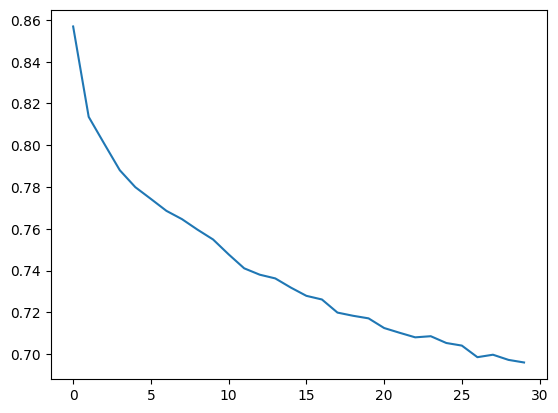

In [21]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '/plots/'+'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'/plots/' + 'loss_plt_500_padding_30_epochs.pdf')
